# Example Masks

In this notebook, we plot some example 2D and 3D FMix masks. For more info and other examples, have a look at [our README](https://github.com/ecs-vlc/fmix).

**Note**: The easiest way to use this is as a colab notebook, which allows you to dive in with no setup.

## Load Dependencies - Colab Only

If you're using Google colab - run this cell: 

In [1]:
from os.path import exists
if not exists('fmix.zip'):
    !wget -O fmix.zip https://github.com/ecs-vlc/fmix/archive/master.zip
    !unzip -qq fmix.zip
    !mv FMix-master/* ./
    !rm -r FMix-master

## 2D Masks

First, some imports and variables:

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchvision.utils import save_image, make_grid

import numpy as np
from fmix import make_low_freq_image, binarise_mask

%matplotlib inline
import matplotlib.pyplot as plt

DECAY_POWER = 3
SHAPE = 32
LAMBDA = 0.5
NUM_IMAGES = 12

Now some sample data from CIFAR-10:

In [3]:
testset = torchvision.datasets.CIFAR10(root='./data/cifar', train=False, download=True,
                                       transform=transforms.Compose([transforms.ToTensor()]))
testgen = torch.utils.data.DataLoader(testset, batch_size=NUM_IMAGES * 2, shuffle=True)
batch, _ = next(iter(testgen))

batch1 = batch[:NUM_IMAGES]
batch2 = batch[NUM_IMAGES:]

Files already downloaded and verified


Next, we create some greyscale images and binary masks using the `make_low_freq_image` and `binarise_mask` method. We then create mixed images by point-wise mutliplying with the CIFAR-10 images:

In [4]:
soft_masks_np = [make_low_freq_image(DECAY_POWER, [SHAPE, SHAPE]) for _ in range(NUM_IMAGES)]
soft_masks = torch.from_numpy(np.stack(soft_masks_np, axis = 0)).float().repeat(1, 3, 1, 1)

masks_np = [binarise_mask(mask, LAMBDA, [SHAPE, SHAPE]) for mask in soft_masks_np]
masks = torch.from_numpy(np.stack(masks_np, axis = 0)).float().repeat(1, 3, 1, 1)

mix = batch1 * masks + batch2 * (1 - masks)

Finally, cat our examples together and save an image:

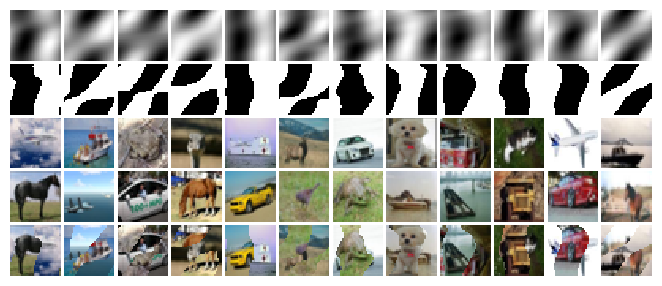

In [5]:
image = torch.cat((soft_masks, masks, batch1, batch2, mix), 0)
save_image(image, 'fmix_example.png', nrow=NUM_IMAGES, pad_value=1)

plt.figure(figsize=(12, 5))
plt.imshow(make_grid(image, nrow=NUM_IMAGES, pad_value=1).permute(1, 2, 0).numpy())
_ = plt.axis('off')

## 3D Masks

For 3D masks the process is very similar. We won't mix any data this time. Instead we'll create a video of the mask using the third dimension as time. First, some dependencies, imports and variables:

In [6]:
!pip install -q moviepy
!pip install -q imageio
!pip install -q imageio-ffmpeg

from IPython.display import clear_output, Image, display, HTML
import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from PIL import Image

FPS = 24
SHAPE = 512
NUM_FRAMES = 512

Now we create a render function which will make the video:

In [7]:
def render_slices(mask, fps):
    frames = mask.size(0)
    size = mask.size(1)
    
    writer = FFMPEG_VideoWriter('fmix_3d.mp4', (size, size), fps)
    for i in range(frames):
        writer.write_frame(Image.fromarray(np.uint8(mask[i].mul(255).unsqueeze(2).repeat(1, 1, 3).numpy())))
    writer.close()
    display(mpy.ipython_display('fmix_3d.mp4', height=400))

Finally, create a 3D mask and pass it to the render function:

In [8]:
mask = make_low_freq_image(3, [SHAPE, SHAPE, NUM_FRAMES])
mask = binarise_mask(mask, 0.5, [SHAPE, SHAPE, NUM_FRAMES])
mask = torch.from_numpy(mask)[0].permute(2, 0, 1)

render_slices(mask, FPS)